In [1]:
# Classes and routines to load in and visualize network failure data.
# Created by: tony.held@gmail.com
# Last updated: 2020/09/12

# Usage: 
#     1) consider adjusting the working directory if you have truoble locating the error log file weight_node_node2.txt
#     2) Shift-Enter all cells or Kernel->Restart & Run All
#     3) Interact with the figure created in the last output

# weight_node_node2.txt is the same as weight_node_node.txt with a single header line inserted
# It's first 3 lines are:
#    fails sender receiver
#    1 10.12.3.248 10.12.4.236
#    1 10.12.3.248 10.12.4.237
#    1 10.12.3.248 10.12.4.90
#    

In [2]:
# Change directory to the location of your network error log file
import os
print(f'Current Working Directory: {os.getcwd()}')

if False:
    new_dir = r"D:\Google Drive\My Documents\code\python\Pycharm Projects\Network Log Analysis"

    os.chdir(new_dir)
    print(f'Current Working Directory: {os.getcwd()}')

In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import plotly.graph_objects as go
import ipaddress    # for sorting ip addresses
import random
from math import ceil
import sys
import ipywidgets as widgets
from IPython.display import display

import pprint
pp = pprint.PrettyPrinter(indent=4)     # pretty printer

In [4]:
class NetworkLogReader:
    """Read server error logfile and its process results."""
    def __init__(self, file_name, max_lines=None):
        """Initialize NetworkLogReader.

        Parameters
        ----------
        file_name : str
            Filename of network failure log.

        max_lines : Non|int
            Maximum number of lines read from the failure log.
            Use None unless debugging, see read_log_file for details.
        """
        self.read_log_file(file_name, max_lines)

        # Create networkx objects and find the relation between nodes in the network
        # self.initialize_network(max_edges=50)
        self.initialize_network()

        # Organize the nodes in the network so they have a x, y coordinate representation.
        self.layout_network(order_by_ip=True, rectangular_grid=True)

        # Calculate additional plot features (edge locations) and annotations based on the network layout.
        self.calc_plot_data()

    def read_log_file(self, file_name, max_lines=None):
        """Read network error data from file_name and process key statistics.

        This function uses panda to read the text file, create pivot tables, and store
        key statistics in numpy variables.

        Parameters
        ----------
        file_name : str
            Filename of network failure log.

        max_lines : None|int
            Maximum number of lines read from the failure log.  Use None unless debugging
            or examining large networks that result in unwieldy figures.
                None - All lines read from failure log.
                int - Only the last int lines of the read_log_file data are used.
                      If the log file was sorted ascending in number of errors,
                      using the last lines likely selects the the most poorly behaving nodes.
        """
        self.file_name = file_name

        # Read in the network data file through panda
        self.panda_df = pd.read_csv(self.file_name, delim_whitespace=True)
        # print(self.panda_df.head())

        # Only examine a part of the log file if requested.
        if max_lines is not None:
            self.panda_df = self.panda_df[-max_lines:]

        # Create pivot tables of receiver and sender failures
        self.pivot_receiver = self.panda_df.pivot_table(values='fails', index='receiver', aggfunc=np.sum)
        self.pivot_receiver.sort_values(by=['fails'], inplace=True, ascending=False)
        self.pivot_sender = self.panda_df.pivot_table(values='fails', index='sender', aggfunc=np.sum)
        self.pivot_sender.sort_values(by=['fails'], inplace=True, ascending=False)
        # print(pivot_receiver)
        # print(pivot_sender)

        # Export raw panda dataframes to numpy variables
        # The node-order of these arrays is the same as that of the original datafile
        self.fails = self.panda_df['fails'].to_numpy()
        self.sender = self.panda_df['sender'].to_numpy()
        self.receiver = self.panda_df['receiver'].to_numpy()
        # Save logfile data as a tuples of tuples to prevent reordering/corruption of original data
        self.raw_data = tuple(zip(self.sender, self.receiver, self.fails))

        # Export panda pivot tables to numpy variables
        # The order of these arrays is sorted descending by number of fails
        self.sender_fails_name = self.pivot_sender.index.to_numpy()  # network name of sender
        self.receiver_fails_name = self.pivot_receiver.index.to_numpy()  # network name of receiver
        self.sender_fails_count = self.pivot_sender['fails'].to_numpy()  # number of fails from sender
        self.receiver_fails_count = self.pivot_receiver['fails'].to_numpy()  # number of fails from receiver

        # Save failures as dictionaries for later lookup
        self.sender_fails_dict = dict(zip(self.sender_fails_name, self.sender_fails_count))
        self.receiver_fails_dict = dict(zip(self.receiver_fails_name, self.receiver_fails_count))
        self.total_fails_dict = self.add_dicts(self.sender_fails_dict, self.receiver_fails_dict)

        # Find unique node names and sort them by ip address
        self.unique_nodes = set(self.sender_fails_name).union(set(self.receiver_fails_name))
        self.unique_nodes = sorted(self.unique_nodes, key=ipaddress.IPv4Address)

        # Print diagnostic information
        print(f'{len(self.fails)} lines successfully read from file: {self.file_name}')
        print(f'{np.sum(self.fails)} total errors detected.')
        print(f'A total of {len(self.unique_nodes)} unique nodes were detected in the log file')
        print(f'{len(self.sender_fails_name)} nodes had send errors.')
        print(f'{len(self.receiver_fails_name)} nodes had receive errors.')

        self.print_top_fails(25)

    def print_top_fails(self, num_of_top=10):
        """Print the top servers with sender & receiver errors.

         Parameters
         ----------
         num_of_top : int
             Number of servers to output.
             For example, num_of_top=15 to show the worst 15 servers
        """
        # Panda will only let you preview a certain number of rows
        # Turn this option off temporarily to allow more rows to be displayed
        max_rows = pd.get_option('display.max_rows')
        pd.set_option('display.max_rows', None)

        print('*'*100)
        print(f'The top {num_of_top} servers with receiving fails')
        print(self.pivot_receiver[:num_of_top])
        print(f'\nThe top {num_of_top} servers with sending fails')
        print(self.pivot_sender[:num_of_top])
        print('*'*100)

        pd.set_option('display.max_rows', max_rows)

    def initialize_network(self):
        """Create networkx objects based on data structures created in read_log_file()
           and create a composite structure dictionary to explore the network in detail.

        Notes
        -------
        1. Primary purpose of this function is to create the self.composite object
            which summaries all network information and who's values can be extracted
            easily into a plot structure.
        2. The self.composite is a dictionary with the following format:
            composite[node][type]
                type can be 'Send Errors', 'Receive Errors', 'Send+Receive Errors',
                            'Send Edges',  'Receive Edges',  'Send+Receive Edges'
            a) if the type ends in 'Errors', composite returns a single numeric with the error count.
            b) if the type ends in 'Edges', composite returns a dictionary.
            c) The edge dictionary is keyed off the other node in the connection
                and its value is the weight between those two nodes.
        3. Examples:
            composite[a]['Send Errors']
                = total number of send errors from "node a" to all other nodes.
            composite[a]['Receive Edges']
                = dictionary of connections between "node a"
                  and all other nodes that "node a" receives errors from
            composite[a][Send+Receive Edges][b]
                = sum of send and receive errors between "node a" and "node b"
        """
        # Select data to include in graph object.
        # Data originally organized such that first node sends and the second receives.
        # Switching the node order changes the context from send error to receive error.
        # The original order analyses send failure, the switched order analyses receive failures for a given node.
        # The send data will likely not have repeat lines, but the receive data likely will.
        send_fails = [(x, y, int(z)) for x, y, z in self.raw_data]
        receive_fails = [(y, x, int(z)) for x, y, z in self.raw_data]

        self.send_graph = self.create_network_graph(send_fails)
        self.receive_graph = self.create_network_graph(receive_fails)
        # Composite combines the send & receive graphs into a single dictionary
        self.composite_dict = self.create_composite_dict(self.send_graph, self.receive_graph)
        print()

    @staticmethod
    def create_network_graph(entries):
        """Create Directional Networkx graph object from list of entries.

        Networkx documentation at: https://networkx.github.io/documentation/stable/

        Parameters
        ----------
        entries : list of 3 member tuples
             Failure data in (sender node, receiver node, number of connections) format.
             If multiple lines have the same sender & receiver, the weighting from each line will be summed.

        Returns
        -------
        d_graph : networkx.DiGraph
             Directional graph created from entries.

        Notes
        -------
        1. networkx has 3 graph objects of interest for this application.
            a) Regular (unspecified):  direction of edge is not important
                adding (A, B) twice will overwrite the first (A, B) entry.
                adding edge(B, A) will overwrite edge(A, B) entry as well since direction is not important.
            b) Directed graphs: direction is import
                connection (A, B) and (B, A) tracked independently.
                adding (A, B) twice will overwrite the first (A, B) entry.
            c) MultiDigraphs: multiple entries for the same edge.
                repeated entries of (A, B) will be tracked independently
        2.  Strategy is to start with a MultiDiGraph in case node parings appear on multiple lines.
                If weights are found on multiple lines, they will be summed for a total weight
                and saved as a directed graph.
        3. networkx determines the order of nodes in output, which may not be in alphabetical/expected order.
        """
        # Create graph that saves directional information and
        # allows for multiple entries for the same node paring
        mdg = nx.MultiDiGraph()
        mdg.add_weighted_edges_from(entries)

        # Create directional graph from multiline graph.
        # Only one entry for each node paring is created.
        # If multiple entries had the same node signature, the weights will be summed into one entry.
        d_graph = nx.DiGraph()
        for send_node, receive_nodes in mdg.adjacency():
            # print(send_node, receive_nodes)
            for receive_node, entries in receive_nodes.items():
                # print("   ", receive_node, entries)
                sum_weights = sum([d['weight'] for d in entries.values()])
                d_graph.add_edge(send_node, receive_node, weight=sum_weights)
        return d_graph

    def create_composite_dict(self, send, receive):
        """Combine sending and receiving graph object information into single dictionary
            to facilitate plotting routines.

        Parameters
        ----------
        send : networkx.DiGraph
            network graph based on sending data.
        receive : networkx.DiGraph
            network graph based on receiving data.

        Returns
        -------
        composite : dict
            Dictionary to facilitate inspection and plotting of network.
        """
        # dictionary for composite network information
        composite = {key: {} for key in self.unique_nodes}

        # Store network adjacency information for sending & receiving node errors
        self.append_adjacency(composite, send, key_name='Send Edges')
        self.append_adjacency(composite, receive, key_name='Receive Edges')

        # Store the summed errors for each node
        for node in self.unique_nodes:
            send_error = self.sender_fails_dict.get(node, 0)
            receive_error = self.receiver_fails_dict.get(node, 0)
            composite[node]['Send Errors'] = send_error
            composite[node]['Receive Errors'] = receive_error
            composite[node]['Send+Receive Errors'] = send_error + receive_error
            composite[node]['Send+Receive Edges'] = self.add_dicts(composite[node]['Send Edges'],
                                                                   composite[node]['Receive Edges'])
        # pp.pprint(composite)
        return composite

    @staticmethod
    def append_adjacency(composite, net_graph, key_name):
        """Extract adjacency information from a networkx graph object and add it to a composite dictionary.

        Parameters
        ----------
        composite : dict
            Dictionary to append information from net_graph.
        net_graph : networkx.DiGraph
            network graph obj that contains either sending or receiving data.
        key_name : str
            Key used to append data to the composite dict.
        """
        for adj in net_graph.adjacency():
            (node_a, connections) = adj
            composite[node_a][key_name] = {}
            for node_b, w in connections.items():
                composite[node_a][key_name][node_b] = w['weight']

    @staticmethod
    def add_dicts(d1, d2):
        """Add contents of two dictionaries together.
           If both dictionaries have the same key, sum the associated value from both dictionaries.

        Parameters
        ----------
        d1 : dict
        d2 : dict

        Returns
        -------
        d3 : dict
            Combined dictionary with summed contents of d1 and d2.

        Notes
        -------
        """
        d3 = d1.copy()
        for k, v in d2.items():
            if k in d3:
                d3[k] = d3[k] + v
            else:
                d3[k] = v
        return d3

    def layout_network(self, order_by_ip=True, rectangular_grid=False):
        """Determine node locations/coordinates to allow visualization/plotting of the network.

        Parameters
        ----------
        order_by_ip : bool
            Set to true if you want node positions lists ordered by ip address.

        rectangular_grid : bool
            Set to true for a grid placement that is roughly rectangular.
             It will not be exactly rectangular because noise is added to avoid edge line overlap.

        Notes
        -------
        1) Various networkx options are listed in layout_types below.  Pick any compatible layout.
        2) networkx layouts return dictionaries that can't be sorted.
            The order_by_ip option re-orders node locations based on how the layout
            dictionary is iterated, which may or may not improve plot readability.

        See: https://networkx.github.io/documentation/stable/reference/drawing.html"""

        # networkx routines to find node layout
        # Each returns a dictionary of positions keyed by node.  The positions are [x, y].
        layout_types = [nx.bipartite_layout, nx.circular_layout, nx.kamada_kawai_layout, nx.planar_layout,
                        nx.random_layout, nx.rescale_layout, nx.rescale_layout_dict, nx.shell_layout,
                        nx.spring_layout, nx.spectral_layout, nx.spiral_layout, nx.multipartite_layout]

        if rectangular_grid:
            # Custom square layout with noise created to best spread network sorted by IP address
            self.node_positions = self.square_layout(self.send_graph, noise=0.15)
        else:
            # Choose any of the layout_types for line below
            self.node_positions = nx.spiral_layout(self.send_graph)

        # Sort node locations by ip address if the user requests.
        # It is not clear the order of the nx layouts since they are dictionaries that can't be sorted
        # Re-ordering may/may not improve plot readability, but it won't corrupt the node coordinates
        if order_by_ip:
            # Extract nodes from position dictionary then sort them in a list
            tmp = {}
            node = (i for i in sorted(self.node_positions.keys(), key=ipaddress.IPv4Address))
            for k, v in self.node_positions.items():
                tmp[next(node)] = v
            self.node_positions = tmp

    @staticmethod
    def square_layout(net_graph, noise=0.17):
        """Custom node layout routine to arrange nodes in a square-ish format to facilitate grouping
        nodes in order by ip address.

        This layout algorithm is an alternative to the standard nx layout routines.

        A grid is created on an x, y coordinate system approximately ranging from 0, 0 to 1, 1.
        Random noise is added to the coordinates so that nodes don't line up perfectly.
        The noise makes for easier to read plots because it reduced node connection overlap.

        Parameters
        ----------
        net_graph : nx.DiGraph
            networkx graph object (used to determine node names & weights).

        noise : float
            Fraction of random noise added to each node location to avoid having a perfectly straight grid.

        Returns
        -------
        return_dict : dic
            Dictionary keyed off node name with [x, y] values in same format as networkx layout return types.
        """
        def next_node(node_count):
            """Nested generator function to determine node coordinates of the next
                node using a square layout with random noise added

            Parameters
            ----------
            node_count : int
                Total number of nodes to visualize in a square-ish grid

            Returns
            -------
            coord : 2 member list of float [x, y]
                x,y coordinates of the next location in the grid spacing.
            """
            # Assume layout is square-ish, ceil (rounding up) will ensure max capacity
            nodes_per_axis = ceil(node_count ** 0.5)
            max_nodes = nodes_per_axis ** 2
            spacing = 1/nodes_per_axis

            # Loop through coordinate structure and add a little noise
            for y in (j*spacing for j in range(nodes_per_axis)):
                for x in (i*spacing for i in range(nodes_per_axis)):
                    noise1 = random.uniform(-spacing, spacing) * noise
                    noise2 = random.uniform(-spacing, spacing) * noise
                    coord = [x+noise1, y+noise2]
                    yield coord

        # Create location dictionary
        return_dict = {}

        # Sort node names as if they were IP addresses
        sorted_nodes = sorted(net_graph.nodes.keys(), key=ipaddress.IPv4Address)
        nn = next_node(len(sorted_nodes))

        for n in sorted_nodes:
            return_dict[n] = next(nn)
        return return_dict

    def calc_plot_data(self):
        """Create easy-to-plot structures for the nodes, hover information, connections, and weights
            based on self.composite_graph, self.node_positions, and self.unique_nodes attributes.

        Notes
        -------
        1. Primary purpose of this function is to create the self.plot_data object
            which summaries network information in an easily plotted structure.
        2. The self.plot_data is a dictionary with the following attributes:
             plot_data['Node Names']
             plot_data['Node Coordinates']
             plot_data[n][edge_type][data_type]

            where:
                n: is the node of interest
                edge_type can be: 'Send', 'Receive', 'Send+Receive'
                data_type can be:
                    'edge_coordinates', 'line_data', 'shape_data',
                    'weights', 'node_text', 'node_color'
        """
        # store all plot data into a dictionary
        self.plot_data = {}

        # store the node names as a tuple that can't be re-ordered
        self.plot_data['Node Names'] = tuple(self.unique_nodes)

        # store node coordinates as a tuple that can't be re-ordered
        temp_x = []
        temp_y = []
        for n in self.unique_nodes:
            temp_x.append(self.node_positions[n][0])
            temp_y.append(self.node_positions[n][1])
        self.plot_data['Node Coordinates'] = tuple([tuple(temp_x), tuple(temp_y)])

        # Plot data to consider for visualization
        edge_types = ['Send', 'Receive', 'Send+Receive']

        for n in self.unique_nodes:
            # print(n)
            self.plot_data[n] = {}
            for edge_type in edge_types:
                self.plot_data[n][edge_type]={}
                # print(edge_type)
                edge_coordinates, line_data, weights = self.find_edge_info(n, edge_type)
                self.plot_data[n][edge_type]['edge_coordinates'] = edge_coordinates
                self.plot_data[n][edge_type]['line_data'] = line_data
                self.plot_data[n][edge_type]['shape_data'] = self.lines_to_shapes(line_data)
                self.plot_data[n][edge_type]['weights'] = weights

                node_text, node_color = self.find_marker_text(n, edge_type)
                self.plot_data[n][edge_type]['node_text'] = node_text
                self.plot_data[n][edge_type]['node_color'] = node_color

    def find_marker_text(self, node_a, edge_type):
        """Calculate marker hover text for plotting purposes.

        Only called by calc_plot_data.

        Parameters
        ----------
        node_a : str
            The node of interest (the one selected in the figure).
        edge_type : ['Send', 'Receive', 'Send+Receive']
            Type of connection to analyse.

        Returns
        -------
        node_text : list of str
            Text to include as hover text in plotly routines that includes a caption for each node
                with a length of self.plot_data['Node Names'].
            For nodes that have a connection with the node of interest, the caption will
                be appended with that individual connection information.

        node_color : list of numeric
            A value for each node is created with the same numeric type as the weight in the original
                error log file (likely integer) with length of self.plot_data['Node Names'].
            These values will be used by plotly to determine the color for each node and the
                range of the associated colorbar.

        Notes
        -------
        1) Plot data is extracted from self.composite_graph.
        2) Node coordinates are determined by self.node_positions.
        """

        # Color node points and determine hover text
        node_color = []
        node_text = []
        for node in self.plot_data['Node Names']:
            node_send_fails = self.sender_fails_dict.get(node, 0)
            node_receive_fails = self.receiver_fails_dict.get(node, 0)
            node_total_fails = self.total_fails_dict.get(node, 0)

            # Have plot color be proportional to desired type of fails count for the node
            if edge_type == 'Send':
                node_color.append(node_send_fails)
            elif edge_type == 'Receive':
                node_color.append(node_receive_fails)
            elif edge_type == 'Send+Receive':
                node_color.append(node_total_fails)
            else:
                raise Exception(f'Unknown edge_type: {edge_type}')

            # Find the hover text for each node
            nt = f"{node} <-> All Nodes: Total={node_total_fails} " \
                 f"Send={node_send_fails} " \
                 f"Receive={node_receive_fails}"

            # Add an additional annotation to the node if connected to the node of interest
            # Showing the fails between these two individual nodes
            my_send = my_receive = my_total = 0

            my_send = self.composite_dict[node]['Send Edges'].get(node_a, 0)
            my_receive = self.composite_dict[node]['Receive Edges'].get(node_a, 0)
            my_total = self.composite_dict[node]['Send+Receive Edges'].get(node_a, 0)

            # Only append information if there is at least one failure to the node of interest.
            if my_total > 0:
                nt += f'<br>{node} <-> {node_a}: Total={my_total}, Send={my_send}, Receive={my_receive}'

            node_text.append(nt)

        return node_text, node_color

    def find_edge_info(self, node_a, edge_type):
        """Calculate edge coordinates and weights for plotting purposes.

        Only called by calc_plot_data.

        Parameters
        ----------
        node_a : str
            The node of interest (the one selected in the figure).
        edge_type : ['Send', 'Receive', 'Send+Receive']
            Type of connection to analyse.

        Returns
        -------
        weights : list
            weight of connection of node_a to its edges
        edge_coordinates : list of form [edge_x, edge_y]
            Coordinates for plotly Scatter routines
            List 0 are the x coordinates, list 1 are the y coordinates
        line_data : list of form [x0, y0, x1, y1, weight]
            Data structure to allow plotly to easily plot each edge connection lines
                separately based on the weight of connections between each node.
                The weight is normalized to range from 0 to 1

        Notes
        -------
        1) Plot data is extracted from self.composite_graph.
        2) Node coordinates are determined by self.node_positions.
        """
        if node_a not in self.node_positions:
            raise Exception(f"Node: {node_a} Not Found in self.node_positions")

        node_a_coordinates = self.node_positions[node_a]
        x0, y0 = node_a_coordinates

        weights = []
        edge_x = []
        edge_y = []
        line_data = []

        # Find the edges associated with specified edge_type
        edge = self.composite_dict[node_a][edge_type + " Edges"]
        # print(f"edge: {edge}")
        # loop through each node in edge to extract weight and coordinate info
        for node_b, weight in edge.items():
            # print(f"node_b: {node_b}")
            weights.append(weight)
            node_b_coordinates = self.node_positions[node_b]
            # Find start/end coordinates for the connecting line based on node location
            x1, y1 = node_b_coordinates
            edge_x.append(x0)
            edge_x.append(x1)
            edge_y.append(y0)
            edge_y.append(y1)
            # You have to end each segment with a None so that all the lines don't connect end-to-end in plotly
            edge_x.append(None)
            edge_y.append(None)
            line_data.append([x0, x1, y0, y1, weight])

        # Save edge_coordinates as a list of lists
        edge_coordinates = [edge_x, edge_y]

        # Save line_data as a numpy array with the weight normalize between 0 and 1
        if line_data:
            line_data = np.asarray(line_data)
            max_weight = np.max(line_data[:, 4])
            line_data[:, 4] = line_data[:, 4] / max_weight
        return edge_coordinates, line_data, weights

    def lines_to_shapes(self, lines, min_weight=0.4, max_weight=3.0):
        """Convert line data to shapes that can be visualized in plotly.

        Parameters
        ----------
        lines : list of form [x0, y0, x1, y1, weight]
                Weight varies from 0 to 1
        min_weight : numeric
            Minimum weight for a plot line, anything below 0.4 is really hard to see.
        max_weight : numeric
            Minimum weight for a plot line, anything greater than 5 obscures nodes.

        Returns
        -------
        shapes : list of dict
            Shape objects suitable for plotly layout inclusion.
        """
        shapes = []
        for line in lines:
            d = {
                'type': 'line',
                'layer': 'below',
                'x0': line[0],
                'y0': line[2],
                'x1': line[1],
                'y1': line[3],
                'line': {
                    'color': 'rgb(50, 171, 96)',
                    # 'color': '#888',
                    'width': min_weight + line[4] * max_weight,
                }
            }
            shapes.append(d)
        return shapes
        pass



In [5]:
class NetworkLogPlotter:
    """Class to plot/visualize NetworkLogReader objects"""

    @staticmethod
    def plot_cumulative_errors(sender_fails, receiver_fails):
        """Visualize the network errors as cumulative distribution plot
         to gain intuition on the number of servers participating in failures.

        Parameters
        ----------
        sender_fails : array-like
            # of sending fails per server
        receiver_fails : array-like
            # of receiving fails per server

        Notes
        -------
        1.  It is assumed that the list is sorted in descending order.
        """
        # Create cumulative sum of fails
        sender_fails_total = np.sum(sender_fails)
        sender_fails_cumulative = np.cumsum(sender_fails)
        sender_fails_percent = sender_fails_cumulative / sender_fails_total * 100

        receiver_fails_total = np.sum(receiver_fails)
        receiver_fails_cumulative = np.cumsum(receiver_fails)
        receiver_fails_percent = receiver_fails_cumulative / receiver_fails_total * 100

        # Plot the cumulative fail data via matplotlib
        fig1, ax1 = plt.subplots(1)
        ax1.plot(sender_fails_percent, '-', label=f"Sender Fails")
        ax1.plot(receiver_fails_percent, '-', label=f"Receiver Fails")
        ax1.set_xlabel('Number of Servers')
        ax1.set_ylabel('Percent of Failures')
        ax1.legend()
        ax1.set_title(f"# of Server's Involved in {receiver_fails_total} Total Fails")
        plt.show()

    @staticmethod
    def plot_network1(nx_graph, plot_data):
        """Visualize network with built in networkx and matplotlib routines.

        This can run very slowly!  Use customized plot routines (plot_network3) instead.

        Parameters
        ----------
        nx_graph :
            networkx.graph object
        plot_data : dict
            plot_data object created by NetworkLogReader
        """
        plot_types = [nx.draw, nx.draw_networkx, nx.draw_kamada_kawai, nx.draw_spring]

        # plot using the networkx built-in drawing routines
        fig1, ax1 = plt.subplots(1)
        nx.draw(nx_graph, with_labels=False)

        x = plot_data['Node Coordinates'][0]
        y = plot_data['Node Coordinates'][1]

        # plot using matplotlib using coordinates from layout data
        fig2, ax2 = plt.subplots(1)
        # x = self.node_coordinates[:, 0]
        # y = self.node_coordinates[:, 1]
        ax2.plot(x, y, 'bx')

        plt.show()

    @staticmethod
    def plot_network3(nlr, plot_node, edge_type):
        """Visualize NetworkLogReader object with customized plotly routines.

        Parameters
        ----------
        nlr : NetworkLogReader
            Plot based on plot_data attribute.
        plot_node: str
            The node of interest (the one selected in the figure).
        edge_type : ['Send', 'Receive', 'Send+Receive']
            Type of connection to analyse.

        Returns
        -------
        fig : plotly.graph_objs._figurewidget.FigureWidget
            Figure widget capable of responding to click events

        Notes
        -------
        """
        nlp = NetworkLogPlotter

        # Step 1.  Gather plot input based on nlr, node, edge_type
        # -------------------------------------------------------------
        # Lines that represent the edges between nodes
        shapes = nlr.plot_data[plot_node][edge_type]['shape_data']

        # Node locations
        x_coord = nlr.plot_data['Node Coordinates'][0]
        y_coord = nlr.plot_data['Node Coordinates'][1]

        # Node color and hover text
        node_text = nlr.plot_data[plot_node][edge_type]['node_text']
        node_color = nlr.plot_data[plot_node][edge_type]['node_color']

        # Step 2.  Create trace and figure with edge trace in the layout
        # -------------------------------------------------------------
        node_trace = nlp.create_scatter(edge_type, node_color, node_text, x_coord, y_coord)
        fig = nlp.create_figure(plot_node, node_trace, shapes);
        fig.write_html("network_errors.html")
        return fig

    @staticmethod
    def create_scatter(edge_type, node_color, node_text, x_coord, y_coord):
        """Create plotly scatterplot.

        Parameters
        ----------
        edge_type : ['Send', 'Receive', 'Send+Receive']
            Type of connection to analyse.
        node_color : list of numeric
            A value for each node is created with the same numeric type as the weight in the original
                error log file (likely integer) with length of self.plot_data['Node Names'].
        node_text : list of str
            Text to include as hover text in plotly routines that includes a caption for each node
                with a length of self.plot_data['Node Names'].
        x_coord : [float]
            x coordinates of nodes
        y_coord : [float]
            y coordinates of nodes

        Returns
        -------
        scatter : plotly.graph_objs._scatter.Scatter
            plotly scatter plot
        """
        scatter = go.Scatter(
            x=x_coord, y=y_coord,
            mode='markers',
            hoverinfo='text',
            text=node_text,
            marker=dict(
                showscale=True,
                # colorscale options
                # 'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
                # 'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
                # 'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
                colorscale='Reds',
                #                reversescale=True,
                color=node_color,
                size=10,
                colorbar=dict(
                    thickness=15,
                    title=f'Num of Failures<br>{edge_type}',
                    xanchor='left',
                    titleside='right'
                ),
                line_width=2))
        return scatter

    @staticmethod
    def create_figure(plot_node, node_trace, my_shapes):
        """Create a plotly figure based on node trace and edge shape

        Parameters
        ----------
        plot_node: str
            The node of interest (the one selected in the figure).
        node_trace : plotly.graph_objs._scatter.Scatter
            Scatter plot of node location
        my_shapes : [dict]
            Shape objects suitable for plotly layout inclusion.

        Returns
        -------
        fig : plotly.graph_objs._figurewidget.FigureWidget
            Figure widget capable of responding to click events
        """
        fig = go.FigureWidget(data=[node_trace],
                         layout=go.Layout(
                             title=f'Interactive Graph of Network Failures<br>Selected Node: {plot_node}',
                             titlefont_size=16,
                             showlegend=False,
                             hovermode='closest',
                             margin=dict(b=20, l=5, r=5, t=40),
                             annotations=[dict(
                                 text="<a href='https://www.youtube.com/watch?v=dQw4w9WgXcQ'> Click me for more info</a>",
                                 showarrow=False,
                                 xref="paper", yref="paper",
                                 x=0.005, y=-0.002)],
                             xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                             yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                             shapes=my_shapes)
                         )
        return fig

    @staticmethod
    def update_figure(fig, nlr, plot_node, edge_type):
        """Update network figure based on change in plot_node and/or edge_type.

        Parameters
        ----------
        fig : plotly.graph_objs._figurewidget.FigureWidget
            Original figure created by create_figure(...)
        nlr : NetworkLogReader
            Plot based on plot_data attribute.
        plot_node: str
            The node of interest (the one selected in the figure).
        edge_type : ['Send', 'Receive', 'Send+Receive']
            Type of connection to analyse.
        """

        # Lines that represent the edges between nodes
        my_shapes = nlr.plot_data[plot_node][edge_type]['shape_data']

        # Node color and hover text
        node_text = nlr.plot_data[plot_node][edge_type]['node_text']
        node_color = nlr.plot_data[plot_node][edge_type]['node_color']

        # update scatter trace
        scatter = fig.data[0]
        scatter.text = node_text
        scatter.marker.color = node_color
        scatter.marker.colorbar.title = f'Num of Failures<br>{edge_type}'

        # update figure layout
        fig.layout.title = f'Interactive Graph of Network Failures<br>Selected Node: {plot_node}'
        fig.layout.shapes = my_shapes

2917 lines successfully read from file: weight_node_node2.txt
11486 total errors detected.
A total of 175 unique nodes were detected in the log file
175 nodes had send errors.
38 nodes had receive errors.
****************************************************************************************************
The top 25 servers with receiving fails
             fails
receiver          
10.12.4.13    1490
10.12.4.93     875
10.12.4.109    691
10.12.4.245    530
10.12.4.1      475
10.12.5.13     463
10.12.5.61     454
10.12.5.5      454
10.12.5.77     446
10.12.5.85     445
10.12.6.53     442
10.12.5.45     439
10.12.4.253    437
10.12.4.17     432
10.12.4.237    426
10.12.4.0      414
10.12.5.21     408
10.12.5.53     395
10.12.3.248    378
10.12.4.229    373
10.12.5.29     362
10.12.3.249    337
10.12.4.16     285
10.12.4.90      12
10.12.4.234      4

The top 25 servers with sending fails
             fails
sender            
10.12.5.32     160
10.12.4.224    155
10.12.5.80     150
10.12.5

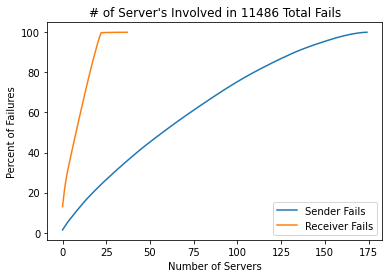

In [6]:
# Use NetworkLogReader and NetworkLogPlotter to create a interactive figure
    
# Read in Error Log file and inspect contents
# This is the same file Ryan sent with a one line header
file_name = "weight_node_node2.txt"
nlr = NetworkLogReader(file_name)
nlp = NetworkLogPlotter()

# Create cumulative error figure
nlp.plot_cumulative_errors(nlr.sender_fails_count, nlr.receiver_fails_count)

# Create (but don't show) an interactive network figure based on desired edge_type and node

# edge_types = ['Send', 'Receive', 'Send+Receive']
edge_type = 'Send+Receive'
plot_node = nlr.receiver_fails_name[0]

fig01 = nlp.plot_network3(nlr, plot_node, edge_type)

In [7]:
# Create interactive wigets/callback to create interactive network figure

# data to display in widgets
node_names = list(nlr.unique_nodes)
num_nodes = len(node_names)
edge_types = ['Send', 'Receive', 'Send+Receive']

# wigets
slider = widgets.IntSlider(
            min=0, 
            max = num_nodes -1,
            value = 1,
            description = 'Node #: ')

slider_label = widgets.Label(value="Node Name: ")

node_hb = widgets.HBox([slider, slider_label])

drop = widgets.Dropdown(
            options=edge_types,
            value=edge_types[1],
            description='Errors: ',
            disabled=False,)

drop_label = widgets.Label(value="Error Type: ")
    
drop_hb = widgets.HBox([drop, drop_label])


# widget handlers
def on_slider_value_change(change):
    new_node_number = change['new']
    new_node_name = node_names[new_node_number]
    slider_label.value = f'Node Name: {new_node_name}'
    nlp.update_figure(fig01, nlr, plot_node=new_node_name, edge_type=drop.value)

def on_drop_value_change(change):
    new_edge_type = change['new']
    drop_label.value = f'Error Type:  {new_edge_type}'
    node_name = node_names[slider.value]
    nlp.update_figure(fig01, nlr, plot_node=node_name, edge_type=new_edge_type)

slider.observe(on_slider_value_change, names='value')
drop.observe(on_drop_value_change, names='value')

# Initialize (changing from the instantiated value will invoke the handlers)
slider.value = 0
drop.value = edge_types[2]

# Callback for clicking on the scatterplot
def update_point(trace, points, selector):
    node_id = points.point_inds[0]
    slider.value = node_id
    
scatter = fig01.data[0]
scatter.on_click(update_point)

# display widgets
display(node_hb)
display(drop)
display(fig01)  # Use display when in jupyter

Dropdown(description='Errors: ', index=2, options=('Send', 'Receive', 'Send+Receive'), value='Send+Receive')

FigureWidget({
    'data': [{'hoverinfo': 'text',
              'marker': {'color': [494, 430, 126, 61, 79, 68…